In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import geopandas as gpd
%matplotlib inline
sns.set_theme(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score
import ppscore as pps
import category_encoders as ce
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from catboost import CatBoostClassifier

In [396]:
train_labels = pd.read_csv('train-labels.csv')
train_values = pd.read_csv('train-values.csv')
df_train = pd.merge(train_labels, train_values, on='id')
train_eda = df_train
df_test = pd.read_csv('test-values.csv')
print(len(df_train), len(df_test))

59400 14850


In [397]:
df_train.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Pré-processamente inicial e separação de features

In [406]:
y = df_train.status_group
df = pd.concat([df_train, df_test]).set_index('id')
df.drop('status_group', axis=1, inplace=True)
train_ids = df_train.id.values
test_ids = df_test.id.values

In [407]:
aux_df = pd.DataFrame(index=df.columns, data={'uniques': df.nunique(),
                                                    'type': df.dtypes,
                                                    'nulls': df.isnull().sum(),
                                                    'nulls%': df.isnull().sum()/len(df) * 100
                                                    })
cat_vars = aux_df[aux_df['type'] == 'object'].index
num_vars = aux_df[aux_df['type'] != 'object'].index
aux_df

,uniques,type,nulls,nulls%
amount_tsh,102,float64,0,0.000000
date_recorded,369,object,0,0.000000
funder,2141,object,869,1.170370
gps_height,2456,int64,0,0.000000
installer,2411,object,877,1.181145
longitude,71870,float64,0,0.000000
latitude,71869,float64,0,0.000000
wpt_name,45684,object,0,0.000000
num_private,68,int64,0,0.000000
basin,9,object,0,0.000000


In [408]:
df_train[cat_vars] = df_train[cat_vars].fillna('none')
df_train[num_vars] = df_train[num_vars].fillna(0)

In [409]:
# datetime 

df_train['date'] = pd.to_datetime(df_train['date_recorded'])
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['weekday'] = df_train['date'].dt.weekday
df_train = df_train.drop('date_recorded', axis=1)

df_test['date'] = pd.to_datetime(df_test['date_recorded'])
df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['weekday'] = df_test['date'].dt.weekday
df_test = df_test.drop('date_recorded', axis=1)

In [410]:
# drop scheme name
df_train = df_train.drop('scheme_name', axis=1)
df_test = df_test.drop('scheme_name', axis=1)

### Análise e seleção de Features

<AxesSubplot:>

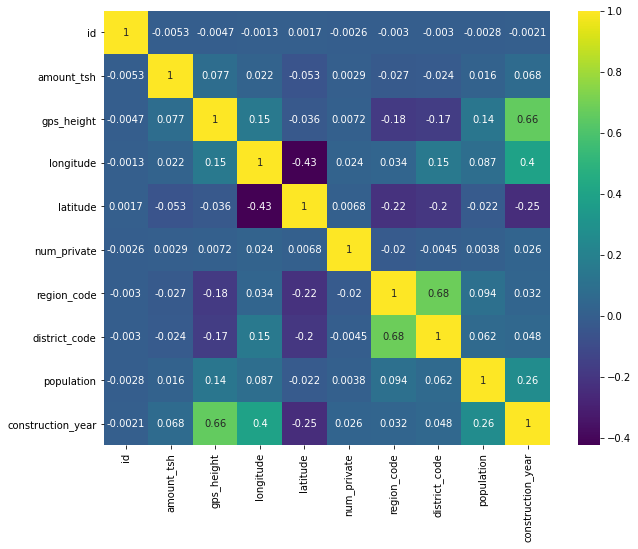

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='viridis')

<AxesSubplot:>

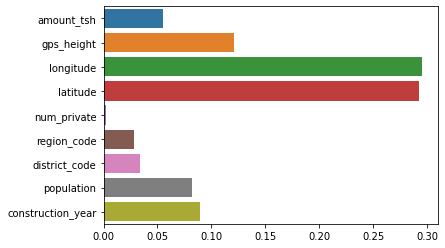

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X=df_train[num_vars], y=df_train.status_group)
importances = rfc.feature_importances_
sns.barplot(x=importances, y=df_train[num_vars].columns)

<AxesSubplot:xlabel='ppscore', ylabel='x'>

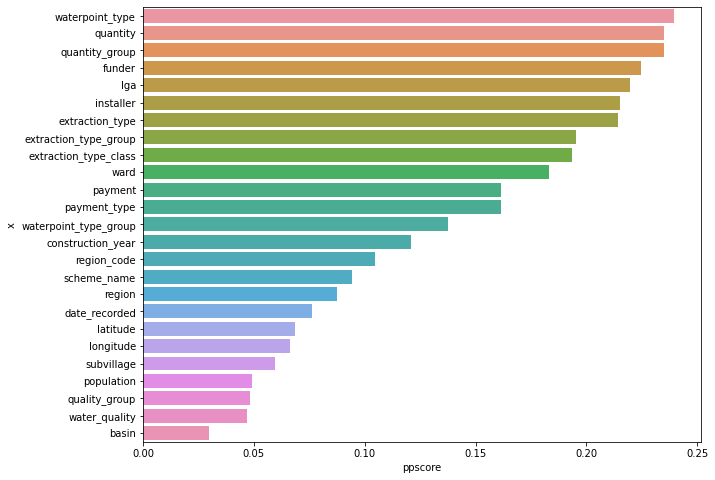

In [50]:
plt.figure(figsize=(10, 8))
predictors_df = pps.predictors(df_train, y='status_group')
sns.barplot(data=predictors_df[predictors_df['ppscore'] != 0], x='ppscore', y='x')

### Análise da variavel target (status_group)

<AxesSubplot:xlabel='status_group', ylabel='count'>

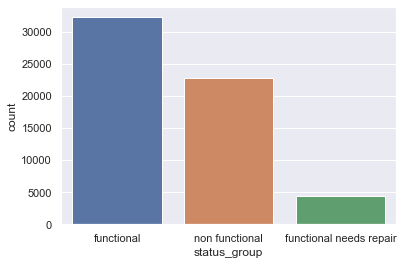

In [247]:
sns.countplot(x='status_group', data=train_eda)

### Analise de features iniciais

0
 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2332        1
 2202        1
 2236        1
-57          1
 2038        1
Name: gps_height, Length: 2428, dtype: int64


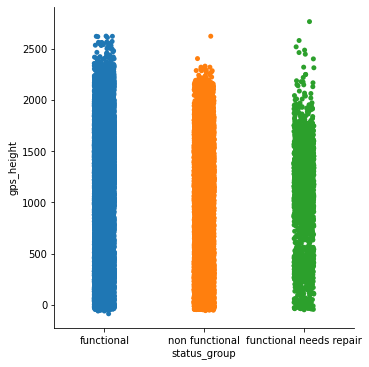

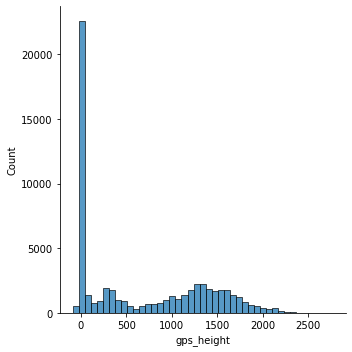

In [91]:
# gps height(atltitude)
print(pps.score(train_eda, 'gps_height', 'status_group')['ppscore'])
print(df_train.gps_height.value_counts())
# sns.boxplot(data=train_eda[train_eda['gps_height'] != 0], x='status_group', y='gps_height')
sns.catplot(data=train_eda[train_eda['gps_height'] != 0], x='status_group', y='gps_height')
sns.displot(train_eda.gps_height)

0.12079138993390813


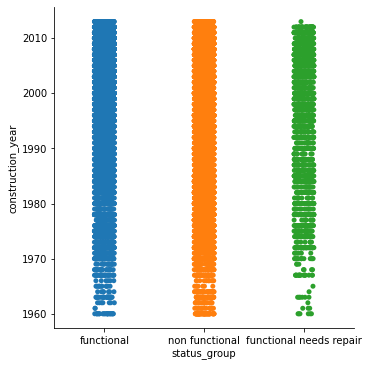

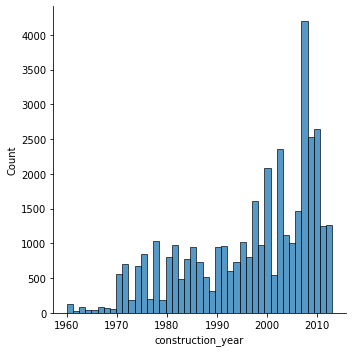

In [93]:
# construction year
print(pps.score(train_eda, 'construction_year', 'status_group')['ppscore'])
# print(df_train.construction_year.value_counts())
# sns.boxplot(data=train_eda[train_eda['construction_year'] != 0], x='status_group', y='construction_year')
sns.catplot(data=train_eda[train_eda['construction_year'] != 0], x='status_group', y='construction_year')
sns.displot(train_eda[train_eda['construction_year'] != 0].construction_year)

<AxesSubplot:xlabel='construction_year', ylabel='gps_height'>

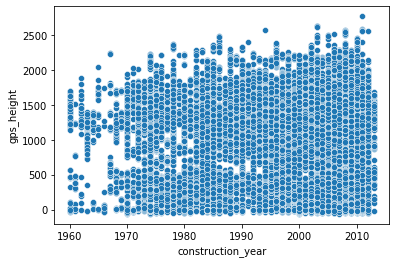

In [89]:
# relacao entre o ano de construcao e altitude - aparentemente inexistente
train_eda.construction_year.value_counts()
sns.scatterplot(data=train_eda[train_eda['construction_year'] != 0], x='construction_year', y='gps_height')

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
14308,49354,functional needs repair,0.0,2013-02-21,Water Board,1084,Water board,36.386050,-4.787678,Mashineni,...,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
30537,12169,functional,0.0,2011-03-12,Government Of Tanzania,184,DWE,38.783756,-5.181904,Mkwajuni,...,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


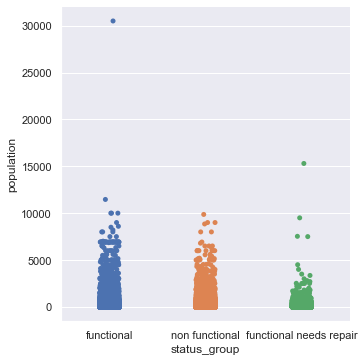

In [157]:
# population
# sns.histplot(train_eda[train_eda['population'] <= 1000]['population'])
sns.catplot(data=train_eda, x='status_group', y='population')
train_eda[train_eda['population'] >= 15000]

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64


<AxesSubplot:xlabel='count', ylabel='waterpoint_type'>

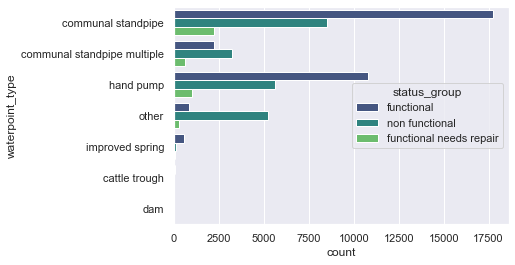

In [156]:
# waterpoint type
print(train_eda['waterpoint_type'].value_counts())
sns.countplot(y='waterpoint_type', data=train_eda, hue='status_group', palette='viridis')

enough          33186
insufficient    15127
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

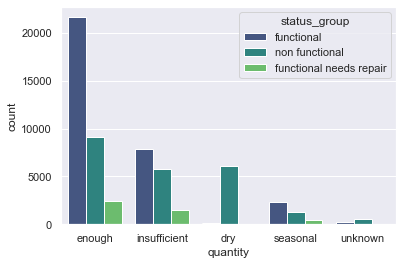

In [208]:
# quantity and quantity group
sns.countplot(data=train_eda, x='quantity', hue='status_group', palette='viridis')
train_eda['quantity'].value_counts()

<AxesSubplot:xlabel='count', ylabel='funder'>

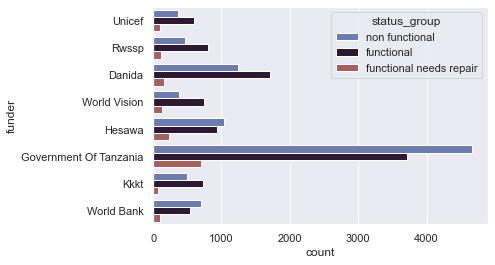

In [258]:
# founder
print(train_eda['funder'].value_counts())
big_funders_df = train_eda[train_eda['funder'].isin([i for i, j in train_eda['funder'].value_counts().iteritems() if j > 1000])]
sns.countplot(y='funder', hue='status_group', data=big_funders_df, palette='twilight')
# sns.countplot(x='status_group', data=big_funders_df, palette='twilight')

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64


<AxesSubplot:xlabel='status_group', ylabel='count'>

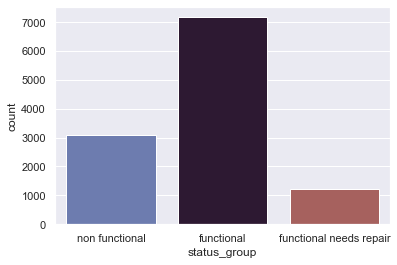

In [265]:
# lga (Geographical location) - local government area
print(train_eda['lga'].value_counts())
big_lga_df = train_eda[train_eda['lga'].isin([i for i, j in train_eda['lga'].value_counts().iteritems() if j >= 1000])]
# sns.countplot(y='lga', hue='status_group', data=big_lga_df, palette='viridis')
sns.countplot(x='status_group', data=big_lga_df, palette='twilight')

Igosi          307
Imalinyi       252
Siha Kati      232
Mdandu         231
Nduruma        217
              ... 
Machinjioni      1
Mawenzi          1
Kinungu          1
Linda            1
Nyamtinga        1
Name: ward, Length: 2092, dtype: int64


<AxesSubplot:xlabel='status_group', ylabel='count'>

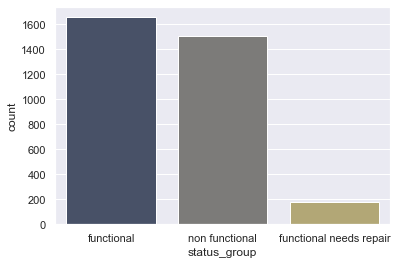

In [273]:
# ward (Geographical location) - Metropolitan and local municipalities are divided into wards
print(train_eda['ward'].value_counts())
big_ward_df = train_eda[train_eda['ward'].isin([i for i, j in train_eda['ward'].value_counts().iteritems() if j <= 10])]
# sns.countplot(y='ward', hue='status_group', data=big_ward_df, palette='viridis')
sns.countplot(x='status_group', data=big_ward_df, palette='cividis')

### Forward dataframe com features selecionadas

In [444]:
df_forward = pd.DataFrame({'Id': df_train.id, 'status_group': df_train.status_group})
df_forward_test = pd.DataFrame({'Id': df_test.id})

print('Df forward initial size:', df_forward.shape)
print('Df forward test initial size:', df_forward_test.shape)

Df forward initial size: (59400, 2)
Df forward test initial size: (14850, 1)


In [445]:
# encode target
label_encoder = LabelEncoder()
ordinal_encoder = ce.OrdinalEncoder()
ordinal_encoder.fit(df_forward['status_group'])
df_forward['status_group_encoded'] = label_encoder.fit_transform(df_forward['status_group'])
print(label_encoder.classes_)
print(ordinal_encoder.mapping)

df_forward = df_forward.drop('status_group', axis=1)

['functional' 'functional needs repair' 'non functional']
[{'col': 'status_group', 'mapping': functional                 1
non functional             2
functional needs repair    3
NaN                       -2
dtype: int64, 'data_type': dtype('O')}]


In [446]:
df_forward['gps_height'] = df_train['gps_height']
df_forward['construction_year'] = df_train['construction_year']
df_forward['latitude'] = df_train['latitude']
df_forward['longitude'] = df_train['longitude']
df_forward['population'] = df_train['population']

df_forward_test['gps_height'] = df_test['gps_height']
df_forward_test['construction_year'] = df_test['construction_year']
df_forward_test['latitude'] = df_test['latitude']
df_forward_test['longitude'] = df_test['longitude']
df_forward_test['population'] = df_test['population']

In [447]:
# latitude + longitude (euclidean distance)
df_forward = df_forward.round({'latitude': 4, 'longitude': 4})
df_forward['latitude_radians'] = np.radians(df_forward['latitude'])
df_forward['longitude_radians'] = np.radians(df_forward['longitude'])
df_forward['x'] = np.cos(df_forward['latitude']) * np.cos(df_forward['longitude'])
df_forward['y'] = np.cos(df_forward['latitude']) * np.sin(df_forward['longitude'])
df_forward['z'] = np.sin(df_forward['latitude'])

df_forward_test = df_forward_test.round({'latitude': 4, 'longitude': 4})
df_forward_test['latitude_radians'] = np.radians(df_forward_test['latitude'])
df_forward_test['longitude_radians'] = np.radians(df_forward_test['longitude'])
df_forward_test['x'] = np.cos(df_forward_test['latitude']) * np.cos(df_forward_test['longitude'])
df_forward_test['y'] = np.cos(df_forward_test['latitude']) * np.sin(df_forward_test['longitude'])
df_forward_test['z'] = np.sin(df_forward_test['latitude'])

In [448]:
# datetime
df_forward['day'] = df_train['day']
df_forward['month'] = df_train['month']
df_forward['year'] = df_train['year']
df_forward['weekday'] = df_train['weekday']

df_forward_test['day'] = df_test['day']
df_forward_test['month'] = df_test['month']
df_forward_test['year'] = df_test['year']
df_forward_test['weekday'] = df_test['weekday']

In [449]:
# population processing
df_forward.loc[df_forward['population'] <= 15000, 'population'] = 10000
df_forward_test.loc[df_forward_test['population'] <= 15000, 'population'] = 10000

In [450]:
# encode waterpoint type encode
target_encoder = ce.TargetEncoder()
df_forward['waterpoint_type_encoded'] = target_encoder.fit_transform(X=df_train['waterpoint_type'], y=df_forward['status_group_encoded'])
df_forward_test['waterpoint_type_encoded'] = target_encoder.transform(X=df_test['waterpoint_type'])

C:\Users\FLAVIO LOSS\anaconda3\envs\aevo\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [451]:
# quantity encode
target_encoder = ce.TargetEncoder()
df_forward['quantity_encoded'] = target_encoder.fit_transform(X=df_train['quantity'], y=df_forward['status_group_encoded'])
df_forward_test['quantity_encoded'] = target_encoder.transform(X=df_test['quantity'])

C:\Users\FLAVIO LOSS\anaconda3\envs\aevo\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [452]:
# funder variabel encode
target_encoder = ce.TargetEncoder()
df_forward['funder_encoded'] = target_encoder.fit_transform(X=df_train['funder'], y=df_forward['status_group_encoded'])
df_forward_test['funder_encoded'] = target_encoder.transform(X=df_test['funder'])

C:\Users\FLAVIO LOSS\anaconda3\envs\aevo\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [453]:
# lga variable encode
target_encoder = ce.TargetEncoder()
df_forward['lga_encoded'] = target_encoder.fit_transform(X=df_train['lga'], y=df_forward['status_group_encoded'])
df_forward_test['lga_encoded'] = target_encoder.transform(X=df_test['lga'])

C:\Users\FLAVIO LOSS\anaconda3\envs\aevo\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [454]:
# ward variable encode
target_encoder = ce.TargetEncoder()
df_forward['ward_encoded'] = target_encoder.fit_transform(X=df_train['ward'], y=df_forward['status_group_encoded'])
df_forward_test['ward_encoded'] = target_encoder.transform(X=df_test['ward'])

C:\Users\FLAVIO LOSS\anaconda3\envs\aevo\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [457]:
df_forward_test

,Id,gps_height,construction_year,latitude,longitude,population,latitude_radians,longitude_radians,x,y,z,day,month,year,weekday,waterpoint_type_encoded,quantity_encoded,funder_encoded,lga_encoded,ward_encoded
0,50785,1996,2012,-4.0597,35.2908,10000,-0.070855,0.615941,0.451232,0.406489,0.794454,4,2,2013,0,1.690752,0.749136,0.241935,0.680135,0.640000
1,51630,1569,2000,-3.3092,36.6567,10000,-0.057756,0.639780,-0.497074,0.851520,0.166824,4,2,2013,0,0.677793,0.857691,1.103809,0.563898,0.772152
2,17168,1567,2010,-5.0043,34.7679,10000,-0.087342,0.606814,-0.281438,-0.060098,0.957696,1,2,2013,4,1.690752,0.857691,0.841162,1.057286,1.340909
3,45559,267,1987,-9.4187,38.0580,10000,-0.164387,0.664237,-0.936271,-0.351227,-0.006078,22,1,2013,1,1.690752,1.943804,1.878788,1.474026,1.586351
4,49871,1260,2000,-10.9504,35.0061,10000,-0.191121,0.610972,0.040691,0.019585,0.998980,27,3,2013,2,0.677793,0.623034,0.312500,0.870667,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,34,1988,-6.5828,38.8527,10000,-0.114892,0.678108,0.387158,0.873495,-0.295152,24,2,2011,3,0.677793,0.623034,0.848748,0.533601,0.669811
14846,18990,0,1994,-5.3504,37.4516,10000,-0.093382,0.653654,0.577448,-0.145917,0.803282,21,3,2011,0,0.705455,0.857691,1.468754,1.086957,0.533333
14847,28749,1476,2010,-4.5856,34.7398,10000,-0.080034,0.606324,0.124355,0.022922,0.991973,4,3,2013,0,0.677793,0.857691,0.841162,1.057286,1.485714
14848,33492,998,2009,-10.5842,35.4327,10000,-0.184729,0.618417,0.256259,0.306963,0.916572,18,2,2013,0,0.677793,0.857691,0.435644,0.741703,0.576923


### Fit tree based model

In [439]:
def model_error(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    return np.mean(score)

In [440]:
# score with cross validation

rfc = RandomForestClassifier()
xgboost = XGBClassifier()

X = df_forward.drop('status_group_encoded', axis=1)
y = df_forward['status_group_encoded']

score_rfc = model_error(rfc, X, y)
# score_xgboost = model_error(xgboost, X, y)

print("Random Forest Score", score_rfc)
# print("XGBoost Score", score_xgboost)

Random Forest Score 0.7954208754208754


In [343]:
# score with train test split

rfc = RandomForestClassifier()
X = df_forward.drop('status_group_encoded', axis=1)
y = df_forward['status_group_encoded']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_valid)
acc_score = accuracy_score(y_valid, predictions)
print(acc_score)

0.7916947250280584


In [458]:
rfc = RandomForestClassifier()

X = df_forward.drop('status_group_encoded', axis=1)
y = df_forward['status_group_encoded']

rfc.fit(X, y)
predict = rfc.predict(df_forward_test)

predict_df = pd.DataFrame({'id': test_ids,
                           'status_group': label_encoder.inverse_transform(predict)}).set_index('id')
print(predict_df['status_group'].value_counts())
predict_df.to_csv('submission_forward_selection.csv')

functional                 8773
non functional             5414
functional needs repair     663
Name: status_group, dtype: int64


### Feature Forward Selection with MLXtend

In [361]:
rfc = RandomForestClassifier()
X = df_forward.drop('status_group_encoded', axis=1)
y = df_forward['status_group_encoded']

sfs = SequentialFeatureSelector(rfc, k_features=5, 
                                forward=True, verbose=1, 
                                scoring='accuracy', cv=5)
sfs = sfs.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  8.0min finished
Features: 1/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.8min finished
Features: 2/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 47.0min finished
Features: 3/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
sfs.subsets_

{1: {'feature_idx': (15,),
  'cv_scores': array([0.66397306, 0.66574074, 0.67011785, 0.66405724, 0.66734007]),
  'avg_score': 0.6662457912457912,
  'feature_names': ('ward_encoded',)},
 2: {'feature_idx': (12, 15),
  'cv_scores': array([0.72205387, 0.71927609, 0.72609428, 0.71641414, 0.7239899 ]),
  'avg_score': 0.7215656565656566,
  'feature_names': ('quantity_encoded', 'ward_encoded')},
 3: {'feature_idx': (11, 12, 15),
  'cv_scores': array([0.76018519, 0.7547138 , 0.75917508, 0.75260943, 0.75984848]),
  'avg_score': 0.7573063973063973,
  'feature_names': ('waterpoint_type_encoded',
   'quantity_encoded',
   'ward_encoded')}}